# Code for [Evoking Syntax: Part 1]()

Below I have attached all of the code I used to run the hypothesis test and generate the plots.  I'm using several wonderful libraries:
- [SpaCy](https://spacy.io/)
- [Numpy](http://www.numpy.org/)
- [Matplotlib](https://matplotlib.org/)

It's main usage is as follows:

**Hypothesis Test**
```python
# First, load the questions data as Tuple[ str, int ]
# The labels will be Pew = 1, Squad = 0
data = load_squad_questions( <filename> ) + load_pew_questions( <filename> )

# Now we will compute the densities of all POS, normalized by tokens
# to get List[ Tuple[ Dict[ POS, float ], int ] ]
pos_densities = list(map(lambda x: (pos_per_x(x[0],'pos','tokens'), x[1]), data))
    
# grab adverb densities
adv_densities = list(map(lambda x: ( x[0].get('ADV',0.0), x[1] ), pos_densities ))
adv0 = list(map(lambda x: x[0], filter(lambda x: x[1] == 0, adv_densities )))
adv1 = list(map(lambda x: x[0], filter(lambda x: x[1] == 1, adv_densities )))

# run the hypothesis test
import scipy.stats
scipy.stats.ttest_ind( adv0, adv1, equal_var=False )
```

**Plots**
```python
# First, load the questions data as Tuple[ str, int ]
# The labels will be Pew = 1, Squad = 0
data = load_squad_questions( <filename> ) + load_pew_questions( <filename> )

# Now we just plot
plot_pos_per_x_distributions( data, 'pos', 'tokens' )
```

In [1]:
##
# Common imports

import logging
import datetime
import json
import yaml
import io

##
# The venerable Numpy library .... always good to have
import numpy as np

##
# Plotting ... "matlab" style .... inline
%matplotlib inline
import matplotlib.pyplot as plt

##
# Yes, we're doing type hints ....
from typing import *


In [2]:
##
# Setup logger to INFO level and stream to stdout so we can see it on the notebook
import sys
logging.basicConfig( level=logging.INFO, stream=sys.stdout )

In [3]:
##
# For the language parsing, tokenizing and Part-of-Speech tagging
# We'll be using SpaCy with hte small core english dictionary
import spacy
nlp = spacy.load( 'en_core_web_sm')

In [4]:
def _log():
    return logging.getLogger( __name__ )

In [13]:
## =======================================================================

def pos_per_x(
        text: str,
        pos_or_tags: str = 'pos',
        normalize: str = 'tokens' ) -> Dict[ str, float ]:
    """
    Returns a dictionary of the different Part-of-Speech and their 
    counts per X in the given text.
        
    Parameters:
    ----------
    text : str
        The input text to count Parts-of-Speech for
    pos_or_tags : str ( 'pos' | 'tag' )
        Do we compute and count Part-of-Speech ('pos', Default) or Tags ('tag')?
    normalize : str
        The object to normalize the counts with. One of 'tokens' (default) 
        or 'sentences'.
        
    Returns:
    -------
    counts : Dict[ str, float ]
        Returns a dictionary with the keys being the Part-of-Speech (or Tags) 
        found and the values being the number of those per 
        X in the given text.
    """
    
    doc = nlp( text )
    counts = {}
    for tok in doc:
        key = tok.pos_
        if pos_or_tags != 'pos':
            key = tok.tag_
        counts[ key ] = counts.get( key, 0.0 ) + 1.0
    
    # divide counts by number of X
    if normalize == 'tokens':
        denom = float(len(list(doc)))
    elif normalize == 'sentences':
        denom = float(len(list(doc.sents)))
    else:
        raise RuntimeError( "Unknown normalization: '{0}'".format( normalize ))
    for key in counts:
        counts[ key ] /= denom
        
    # return counts
    return counts

## =======================================================================

def plot_pos_per_x_distributions(
        data: Sequence[ Tuple[ str, int ] ],
        pos_or_tags: str = 'pos',
        normalize: str = 'tokens',
        plot_only_pos: str = None,
        title_template: str = "{pos_or_tags} Per {normalize}") -> None:

    start_time = datetime.datetime.now()
    
    # compute poscounts
    pos_data = list(map(lambda d: ( pos_per_x( d[0],
                                               pos_or_tags=pos_or_tags,
                                               normalize=normalize),
                                    d[1] ),
                        data))
    _log().info( "Computed pos_per_x for #data={0} in {1}".format(
        len(data),
        ( datetime.datetime.now() - start_time ) ) )
                                     
    # compute all known pos
    all_pos = set([])
    for poscount, label in pos_data:
        for pos in poscount:
            all_pos.add( pos )
    _log().info( "Total found #pos={0}".format( len(all_pos)) )
    
    if plot_only_pos is not None:
        all_pos = [ plot_only_pos ]

    # ok, let's build a plot with an axes per pos
    k = int(np.ceil(np.sqrt(len(all_pos))))
    fig, axes = plt.subplots( k,k, squeeze=False, figsize=(10.0,8.0) )
    fig.suptitle( title_template.format(
        pos_or_tags=pos_or_tags,
        normalize=normalize ) )
    _log().info( "Building {0}x{0} grid figure".format( k ) )
    for pos, ax in zip(all_pos, axes.reshape(-1).tolist() ):

        # set x axis label
        ax.set_xlabel( pos )

        # compute data per label of pos counts
        pdata = list(map(lambda x: ( x[0].get( pos, 0.0 ), x[1] ), pos_data ))
        data0 = list(map(lambda x: x[0], filter(lambda d: d[1] == 0, pdata)))
        data1 = list(map(lambda x: x[0], filter(lambda d: d[1] == 1, pdata)))
        _log().info( "data0.mean={0:0.2f} #data0={1} data1.mean={2:0.2f} #data1={3}".format(
            np.mean( data0 ),
            len( data0 ),
            np.mean( data1 ),
            len( data1 ) ) )
        ax.hist( [ data0, data1 ], density=True, label=[ '0', '1' ] )
        #ax.legend()
        _log().info( "plotted '{0}'".format( pos ) )

    # layout and adjust for axis labels
    fig.tight_layout()
    fig.subplots_adjust( top=0.95 )

    end_time = datetime.datetime.now()
    _log().info( "Computed an plotted in {0}".format(
        ( end_time - start_time ) ) )

    # done :)
    return fig


In [9]:
## =======================================================================

def load_squad_questions(
        filename: str,
        label: int = 0,
        impossible: Optional[bool] = None) -> Sequence[ Tuple[ str, int ] ]:
    """
    Loads the SQUAD questions from the given json file, returning a sequence of ( X, y )
    tuples where X = question text and Y = label (as given).

    if impossible is None, returns both possible nad impossible SQUAD questions.  Otherwise
    only return questions where the is_impossible attrubte is ture/false as per the given
    parameter.
    """

    # load
    with open( filename ) as f:
        data = json.load( f )

    # ok, grab all the questions form hte dataset
    questions = []
    for doc in data['data']:
        for par in doc['paragraphs']:
            for qa in par['qas']:
                is_impossible = qa.get('is_impossible', False ) # older version were all possible
                if impossible is None or impossible == is_impossible:
                    questions.append( qa['question'] )

    # return a dataset
    datalist = list(map(lambda q: (q,label), questions))
    return datalist

## =======================================================================

def load_pew_questions(
        filename: str,
        label: int = 1 ) -> Sequence[ Tuple[ str, int ] ]:
    """
    """

    # load YAML
    with io.open( filename, mode='r', encoding='utf-8' ) as f:
        data = yaml.load( f )

    # grab only the string items as questions
    questions = filter(lambda x: isinstance( x, str ), data)

    # make data with label and return it
    datalist = list(map(lambda q: (q,label), questions))
    return datalist

## =======================================================================


In [10]:
data = load_squad_questions( 'squad-train-v2.0.json') + load_pew_questions( 'pew_research_questions.yaml')

INFO:__main__:Computed pos_per_x for #data=1000 in 0:00:09.832700
INFO:__main__:Total found #pos=16
INFO:__main__:Building 1x1 grid figure
INFO:__main__:data0.mean=0.70 #data0=683 data1.mean=1.43 #data1=317
INFO:__main__:plotted 'DET'
INFO:__main__:Computed an plotted in 0:00:09.922101


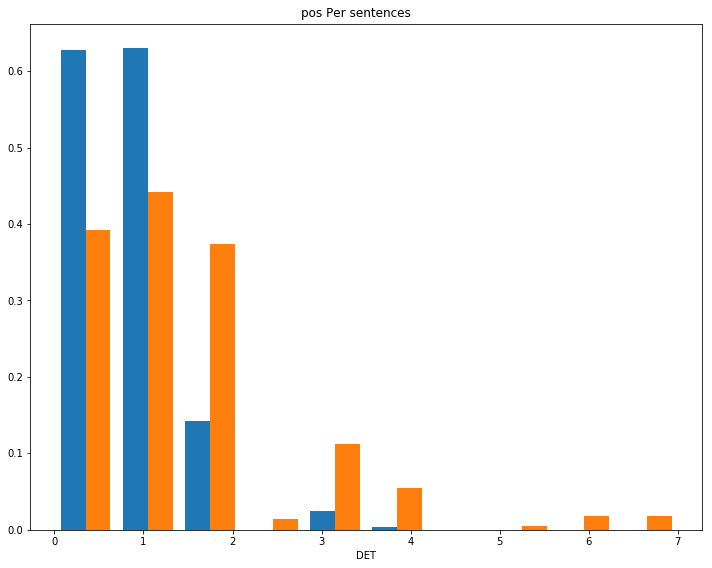

In [15]:
%matplotlib inline
fig = plot_pos_per_x_distributions( data[-1000:], 'pos', 'sentences', 'DET' )
fig.savefig( 'det_per_sentence.svg' )

INFO:__main__:Computed pos_per_x for #data=1000 in 0:00:10.671183
INFO:__main__:Total found #pos=16
INFO:__main__:Building 4x4 grid figure
INFO:__main__:data0.mean=0.00 #data0=683 data1.mean=0.00 #data1=317
INFO:__main__:plotted 'SPACE'
INFO:__main__:data0.mean=0.06 #data0=683 data1.mean=0.08 #data1=317
INFO:__main__:plotted 'DET'
INFO:__main__:data0.mean=0.01 #data0=683 data1.mean=0.01 #data1=317
INFO:__main__:plotted 'NUM'
INFO:__main__:data0.mean=0.11 #data0=683 data1.mean=0.09 #data1=317
INFO:__main__:plotted 'ADP'
INFO:__main__:data0.mean=0.09 #data0=683 data1.mean=0.09 #data1=317
INFO:__main__:plotted 'ADJ'
INFO:__main__:data0.mean=0.26 #data0=683 data1.mean=0.18 #data1=317
INFO:__main__:plotted 'NOUN'
INFO:__main__:data0.mean=0.00 #data0=683 data1.mean=0.00 #data1=317
INFO:__main__:plotted 'SYM'
INFO:__main__:data0.mean=0.09 #data0=683 data1.mean=0.02 #data1=317
INFO:__main__:plotted 'PROPN'
INFO:__main__:data0.mean=0.00 #data0=683 data1.mean=0.00 #data1=317
INFO:__main__:plotte

INFO:__main__:data0.mean=0.00 #data0=683 data1.mean=0.00 #data1=317
INFO:__main__:plotted ''
INFO:__main__:data0.mean=0.01 #data0=683 data1.mean=0.03 #data1=317
INFO:__main__:plotted 'RBS'
INFO:__main__:data0.mean=0.07 #data0=683 data1.mean=0.15 #data1=317
INFO:__main__:plotted 'MD'
INFO:__main__:data0.mean=0.00 #data0=683 data1.mean=0.07 #data1=317
INFO:__main__:plotted 'RBR'
INFO:__main__:data0.mean=0.30 #data0=683 data1.mean=0.14 #data1=317
INFO:__main__:plotted 'VBD'
INFO:__main__:data0.mean=0.01 #data0=683 data1.mean=0.00 #data1=317
INFO:__main__:plotted 'SYM'
INFO:__main__:data0.mean=0.00 #data0=683 data1.mean=0.00 #data1=317
INFO:__main__:plotted 'FW'
INFO:__main__:data0.mean=0.55 #data0=683 data1.mean=0.93 #data1=317
INFO:__main__:plotted 'NNS'
INFO:__main__:data0.mean=0.84 #data0=683 data1.mean=0.38 #data1=317
INFO:__main__:plotted 'NNP'
INFO:__main__:data0.mean=0.00 #data0=683 data1.mean=0.00 #data1=317
INFO:__main__:plotted 'NFP'
INFO:__main__:data0.mean=1.00 #data0=683 data

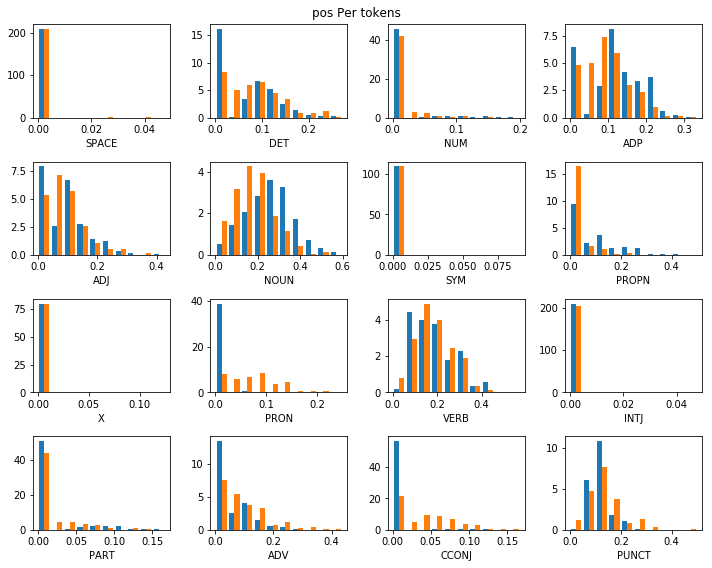

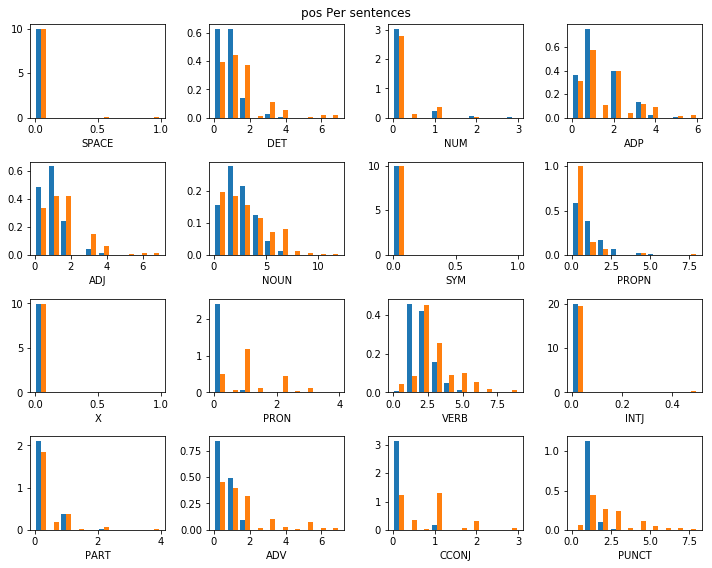

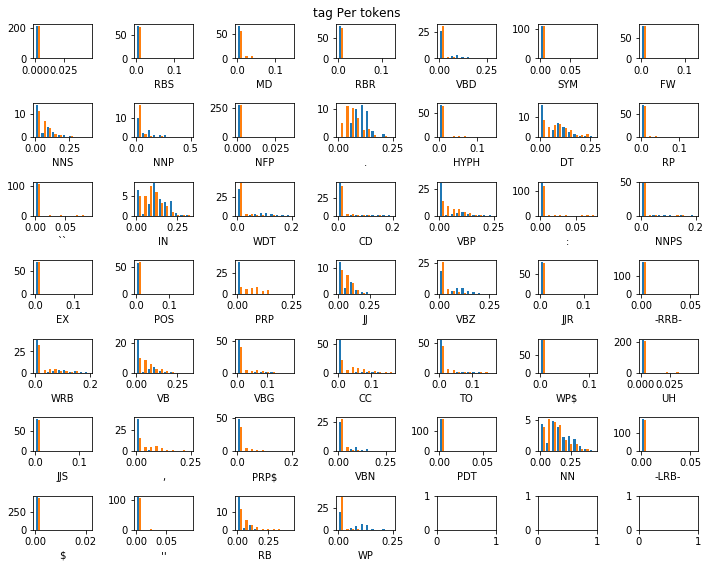

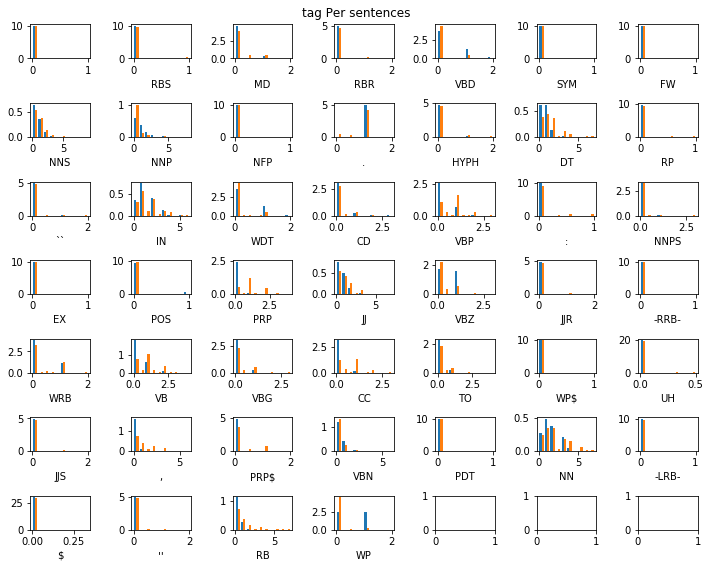

In [62]:
##
# Plot all combinations of POS and TAGS normalized by Tokens or Sentences
# for 1000 datapoints (not hte full data for speed)
%matplotlib inline
import itertools
params = itertools.product( [ 'pos', 'tag' ], ['tokens','sentences'])
for pos, norm in params:
    plot_pos_per_x_distributions( data[-1000:], pos, norm )

In [63]:
# First, load the questions data as Tuple[ str, int ]
# The labels will be Pew = 1, Squad = 0
data = load_squad_questions( 'squad-train-v2.0.json' ) + load_pew_questions( 'pew_research_questions.yaml' )

# Now we will compute the densities of all POS, normalized by tokens
# to get List[ Tuple[ Dict[ POS, float ], int ] ]
pos_densities = list(map(lambda x: (pos_per_x(x[0],'pos','tokens'), x[1]), data))

# grab adverb densities
adv_densities = list(map(lambda x: ( x[0].get('ADV',0.0), x[1] ), pos_densities ))
adv0 = list(map(lambda x: x[0], filter(lambda x: x[1] == 0, adv_densities )))
adv1 = list(map(lambda x: x[0], filter(lambda x: x[1] == 1, adv_densities )))

# run the hypothesis test
import scipy.stats
ttest_res = scipy.stats.ttest_ind( adv0, adv1, equal_var=False )
print( ttest_res )

Ttest_indResult(statistic=-9.85252000171142, pvalue=3.747944550892387e-20)


In [64]:
impossible_data = load_squad_questions( 'squad-train-v2.0.json', impossible=False, label=0) + load_squad_questions( 'squad-train-v2.0.json', impossible=True, label=1)

INFO:__main__:Computed pos_per_x for #data=129319 in 0:21:22.948169
INFO:__main__:Total found #pos=16
INFO:__main__:Building 4x4 grid figure
INFO:__main__:data0.mean=0.00 #data0=86153 data1.mean=0.01 #data1=43166
INFO:__main__:plotted 'SPACE'
INFO:__main__:data0.mean=0.08 #data0=86153 data1.mean=0.07 #data1=43166
INFO:__main__:plotted 'DET'
INFO:__main__:data0.mean=0.01 #data0=86153 data1.mean=0.02 #data1=43166
INFO:__main__:plotted 'NUM'
INFO:__main__:data0.mean=0.11 #data0=86153 data1.mean=0.11 #data1=43166
INFO:__main__:plotted 'ADP'
INFO:__main__:data0.mean=0.10 #data0=86153 data1.mean=0.09 #data1=43166
INFO:__main__:plotted 'ADJ'
INFO:__main__:data0.mean=0.23 #data0=86153 data1.mean=0.24 #data1=43166
INFO:__main__:plotted 'NOUN'
INFO:__main__:data0.mean=0.00 #data0=86153 data1.mean=0.00 #data1=43166
INFO:__main__:plotted 'SYM'
INFO:__main__:data0.mean=0.11 #data0=86153 data1.mean=0.10 #data1=43166
INFO:__main__:plotted 'PROPN'
INFO:__main__:data0.mean=0.00 #data0=86153 data1.mean=

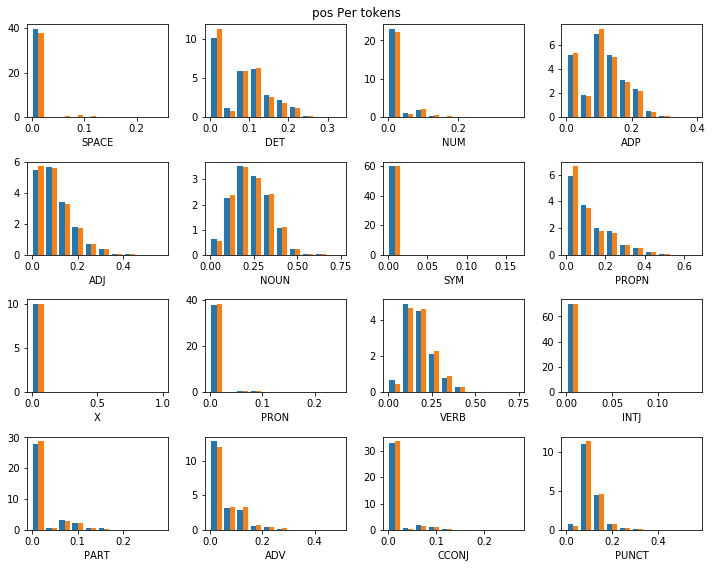

In [65]:
np.random.shuffle( impossible_data )
plot_pos_per_x_distributions( impossible_data[:-1000], 'pos', 'tokens' )

# Now we will compute the densities of all POS, normalized by tokens
# to get List[ Tuple[ Dict[ POS, float ], int ] ]
pos_densities_impossible = list(map(lambda x: (pos_per_x(x[0],'pos','tokens'), x[1]), impossible_data))

# grab adverb densities
adv_densities_impossible = list(map(lambda x: ( x[0].get('ADV',0.0), x[1] ), pos_densities_impossible ))
adv0 = list(map(lambda x: x[0], filter(lambda x: x[1] == 0, adv_densities_impossible )))
adv1 = list(map(lambda x: x[0], filter(lambda x: x[1] == 1, adv_densities_impossible )))

# run the hypothesis test
import scipy.stats
ttest_res = scipy.stats.ttest_ind( adv0, adv1, equal_var=False )
print( ttest_res )

In [66]:
len( list( filter(lambda x: x[1] == 1, impossible_data ) ) )

43498

In [67]:
adv0_a = adv0[:10000]
adv0_b = adv0[-10000:]
sanity_test_res = scipy.stats.ttest_ind( adv0_a, adv0_b, equal_var=False )
print( sanity_test_res )
sane_test_res = scipy.stats.ttest_ind( adv0[:10000], adv1[:10000], equal_var=False)
print( sane_test_res )

Ttest_indResult(statistic=0.5080304563591397, pvalue=0.6114375880857872)
Ttest_indResult(statistic=-5.638765287190908, pvalue=1.7359222136841648e-08)


In [68]:
def _data_size_until_rejection( 
    adv_density_data: Sequence[Tuple[float,int]], 
    pvalue: float = 0.01, 
    chunk: int = 100 ) -> Dict[int,int]:
    """
    Returns the number of data samples for each of the labels needed to reject the hypothesis
    with the given p-value.
        
    This will go through the data *in order* and will apply the hypothesis test every 
    chunk number of data elements until we get rejection with p-value <= pvalue parameter.
    """
    buckets = {}
    i = 0
    while i < len(adv_density_data):
        
        # add the chunk to buckets
        for j in range(min(chunk,len(adv_density_data)-i)):
            d = adv_density_data[i + j]
            if d[1] not in buckets:
                buckets[d[1]] = []
            buckets[d[1]].append( d[0] )
            
        # run hypothesis test
        if len(buckets) > 2:
            raise RuntimeError( "Only implemented but binary labels! Found more than 2 labels")
        if len(buckets) == 2:
            vals = list(buckets.values())
            test_res = scipy.stats.ttest_ind( vals[0], vals[1], equal_var=False )
            if test_res.pvalue <= pvalue:
                break
            
        # update for next chunk
        i += chunk
        
    return dict(map(lambda kv: (kv[0], len(kv[1])), buckets.items()))

In [70]:
def data_size_estimate( adv_data, iterations=100000 ):
    results = []
    for i in range(iterations):
        np.random.shuffle( adv_data )
        res = _data_size_until_rejection( adv_data, 0.05, 100 )
        results.append( res )
    total_size = list(map(lambda res: sum(res.values()), results))
    results_0 = list(map(lambda res: res[0], results))
    results_1 = list(map(lambda res: res[1], results))
    res_total = ( np.mean( total_size ), np.var( total_size ) )
    res_0 = ( np.mean( results_0 ), np.var( results_0 ) )
    res_1 = ( np.mean( results_1 ), np.var( results_1 ) )
    print( res_total )
    print( res_0 )
    print( res_1 )
    plt.hist( total_size )
    return ( res_total, res_0, res_1 )

PEW vs SQUAD 


/home/velezj/projects/forge/repos/blog/chernobyl/blog/javier/language-of-truth/evoking-syntax-part-01/.venv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/velezj/projects/forge/repos/blog/chernobyl/blog/javier/language-of-truth/evoking-syntax-part-01/.venv/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(5417.389, 16198184.322679002)
(5404.18776, 16129455.186166184)
(13.20124, 83.8407624624)
Poosible vs Impossible 
(1775.358, 2746461.5718359994)
(1182.86827, 1220098.6738972072)
(592.48973, 306013.45991452713)


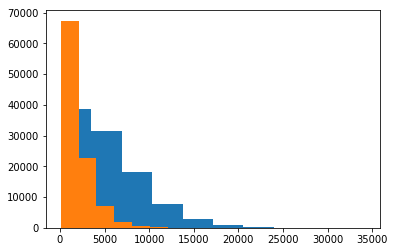

In [71]:
print( "PEW vs SQUAD ")
data_size = data_size_estimate( adv_densities )

print( "Poosible vs Impossible ")
data_size_impossible = data_size_estimate( adv_densities_impossible )

In [75]:
def _balanced_data_size_until_rejection( 
    adv_density_data: Sequence[Tuple[float,int]],
    pvalue: float = 0.01 ,
    chunk: int = 50 ) -> Dict[int,int]:
    """
    """
    data0 = list(map(lambda x: x[0], filter(lambda x: x[1] == 0, adv_density_data)))
    data1 = list(map(lambda x: x[0], filter(lambda x: x[1] == 1, adv_density_data)))
    index0 = 0
    index1 = 0
    len0 = len(data0)
    len1 = len(data1)
    bucket0 = []
    bucket1 = []
    while index0 < len0 and index1 < len1:
        for j in range( min( chunk, len0 - index0 ) ):
            bucket0.append( data0[index0 + j] )
        for j in range( min( chunk, len1 - index1 ) ):
            bucket1.append( data1[ index1 + j ] )
        test_res = scipy.stats.ttest_ind( bucket0, bucket1, equal_var=False )
        if test_res.pvalue <= pvalue:
            break
        index0 += chunk
        index1 += chunk
        
    return { 0: len(bucket0), 1: len(bucket1) }


def balanced_data_size_estimate( adv_data, iterations=100000 ):
    results = []
    for i in range(iterations):
        np.random.shuffle( adv_data )
        res = _balanced_data_size_until_rejection( adv_data, 0.05, 100 )
        results.append( res )
    total_size = list(map(lambda res: sum(res.values()), results))
    results_0 = list(map(lambda res: res[0], results))
    results_1 = list(map(lambda res: res[1], results))
    res_total = ( np.mean( total_size ), np.var( total_size ) )
    res_0 = ( np.mean( results_0 ), np.var( results_0 ) )
    res_1 = ( np.mean( results_1 ), np.var( results_1 ) )
    print( res_total )
    print( res_0 )
    print( res_1 )
    plt.hist( total_size )
    return ( res_total, res_0, res_1 )

PEW vs SQUAD 
(200.792, 158.57273600000008)
(100.396, 39.64318400000002)
(100.396, 39.64318400000002)
Poosible vs Impossible 
(1735.086, 2266643.3726039995)
(867.543, 566660.8431509999)
(867.543, 566660.8431509999)


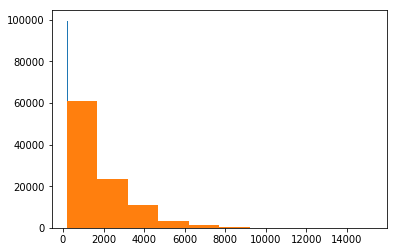

In [77]:
print( "PEW vs SQUAD ")
data_size_balanced = balanced_data_size_estimate( adv_densities )

print( "Poosible vs Impossible ")
data_size_impossible_balanced = balanced_data_size_estimate( adv_densities_impossible )